In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, Dense, Reshape 
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.models import load_model
from numpy import asarray
from numpy import save
from numpy import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import esprima as esp
import re
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model
from keras import Model
import keras
import pydot
import gensim 
from nltk.tokenize import word_tokenize
import pickle
from keras import backend as K

plt.style.use('ggplot')

In [2]:
def save_object(obj, filename):
    with open(filename+".pickle", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

In [3]:
def load_object(filename):
    with open(filename+".pickle", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [111]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [112]:
# def Read_data_and_split(path_csv_file='G:/JSContanaDataSet/script_path_df.csv',my_test_size=0.25):
#     data = pd.read_csv(path_csv_file)
#     columns = data.columns
#     x = data[columns[0]].values
#     y = data[columns[1]].values
#     sentences_train, sentences_test, y_train, y_test = train_test_split(x, y, test_size=my_test_size, random_state=1000)
#     return sentences_train, sentences_test, y_train, y_test

In [113]:
# convert java script code to the abstract syntax tree
# then extract the sequences of syntax units with detailed information
def sequence_of_syntax_units(scripts):
    """
    sctipts : list or single javascript code 
    return sequence of syntax units
    each syntax unit correspond to line in an abstract syntax tree
    """
    if type(scripts) is list:
        # esp.parseScript(script) returns abstract syntax tree of each js scripts
        return [re.sub('\s+', ' ', ''.join(str(esp.parseScript(script)).split('\n'))) for script in scripts]
    elif type(scripts) is str:
        return re.sub('\s+', ' ', ''.join(str(esp.parseScript(scripts)).split('\n')))
    else:
        raise ValueError('The type of scripts parameter must be {list or string}')

In [114]:
# create word tokens
def sequence_of_syntax_units_to_tokens(seq_of_syn_units):
    """
    Convert Sequence of syntax units to tokens to train  word2vec model 
    -----------------------------------------
    seq_of_syn_units: list of sequence syntax units correspond to abstract syntax trees
    """
    return list(map(word_tokenize, seq_of_syn_units))

In [115]:
def extract_js_code_with_no_tag(code):
    return  list(map(lambda x: re.sub(r';', ' ; ', x), re.findall(r'javascript:(.*?\(.*?\))[\\/<>]?', code, re.IGNORECASE)))

In [116]:
 def extract_js_code(script):
    #list all the scripts tags
    internal_js = re.findall(r'<script>?(.*?\(.*?\))[\\/<>]?',script , re.IGNORECASE)
    # remove unwanted words like javascript keyword and quotes 
    # add space befor and after semicolon
    clean_js_codes = []
    for code in internal_js:
        if re.search(r'javascript', code):
            clean_js_codes += extract_js_code_with_no_tag(code)  
        else:
            clean_js_codes.append(re.sub(r';', ' ; ', code))
    r = list(set(clean_js_codes + extract_js_code_with_no_tag(script)))
    if len(r) == 0:
        print(script)
    return r

In [117]:
# def esprima_dataFrame(path="G:/JSContanaDataSet/programs_training.txt",name="esprima_dataFrame"):
#     with open(path, 'r', encoding='utf-8') as file:
#         path_scripts = file.readlines()
#     scripts = []
#     Label = []
#     X = []
#     y = []
#     sub_path = path[:path.rindex("/")+1]
#     for path_script in range(len(path_scripts)-1):
#         try:
#             s_p = sub_path+path_scripts[path_script][:-1]
#             with open(s_p) as js_file:
#                 script = js_file.read()
#                 X.append(sequence_of_syntax_units(script))
#                 if path_script%2==0:
#                     y.append(0)
#                 else:
#                     y.append(1)
#         except:
#             pass
#     df = pd.DataFrame(columns=["ScriptName","Label"])
#     df["ScriptName"] = X
#     df["Label"] = y
#     df.to_csv(sub_path+name+'.csv', index=False)    
#     return df

In [118]:
# def chunking_data(Data,chunkNum):
#     chunkSize = Data.shape[0]/chunkNum
#     temp = []
#     for i in range(chunkNum):
#         satrt = int(i * chunkSize)
#         end = int((i+1) * chunkSize)
#         if Data.shape[0]-end>0:
#             temp.append(Data[satrt:end])
#         else:
#             temp.append(Data[satrt:Data.shape[0]])
#     return temp

In [119]:
# def preprocessing_dataset(num_words,sentences_train,sentences_test,maxlen):
#     tokenizer = Tokenizer(num_words=num_words)
#     tokenizer.fit_on_texts(sentences_train)
#     X_train = tokenizer.texts_to_sequences(sentences_train)
#     X_test = tokenizer.texts_to_sequences(sentences_test)
#     vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
#     X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
#     X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
#     return X_train,X_test,vocab_size

In [ ]:
class CustomDataGen(keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,batch_size,test=0,shuffle=True,sub_path=""):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.sub_path = sub_path
        self.n = len(self.df[self.df.columns[0]])
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        try:
            with open(self.sub_path+path) as js_file:
                script = js_file.read()
            script = sequence_of_syntax_units(script)
            return script
        except:
            return 'None'
    def __get_output(self, label):
        return label
#         return keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batches):

        path_batch = batches[self.X_col['path']]
        
        name_batch = batches[self.y_col['name']]

        X_batch = np.asarray([self.__get_input(x) for x in path_batch]).astype('object')
        
        y_batch = np.asarray([self.__get_output(y) for y in name_batch]).astype('object')
        
        index = np.where(X_batch=='None')[0]
        
        np.delete(X_batch, index, axis=0)
        np.delete(y_batch, index, axis=0)
        
        X_batch  = preprocessing_dataset_(X_batch , test = self.test )
        
        X_batch = K.cast_to_floatx(X_batch)
        y_batch = K.cast_to_floatx(y_batch)
        

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [150]:
# def evaluation(model,history,X_train,y_train,X_test,y_test,t=0):
#     loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
#     print("Training Accuracy: {:.4f}".format(accuracy))
#     loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
#     print("Testing Accuracy:  {:.4f}".format(accuracy))
#     print(classification_report(np.round(model.predict(X_test)), y_test))
#     plot_history(history)

In [152]:
def evaluation(model,history,X_train,X_test):
    loss, accuracy = model.evaluate_generator(X_train)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate_generator(X_test)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
#     model.predict_generator(generator, steps=n_steps, multi_processing=False)
#     print(classification_report(y_pred = np.round(model.predict_generator(X_test)), y_true = y_test))
    plot_history(history)

In [121]:
# def Model(vocab_size,embedding_dim,maxlen,myoptimizer,myloss,mymetrics,shape=100,Type=0):
#     model = Sequential()
#     if Type==0:
#         model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
#         model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
#     else :
#          model.add(layers.InputLayer(input_shape=shape))
        
    
#     model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))

#     # TextCNN with 4 conv layers
#     model.add(Conv1D(128, 7, activation='tanh', input_shape=(None, 32)))
#     model.add(Conv1D(128, 15, activation='tanh'))
#     model.add(Conv1D(128, 25, activation='tanh'))
#     model.add(Conv1D(128, 35, activation='tanh'))
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=myoptimizer,
#                   loss=myloss,
#                   metrics=[mymetrics])
#     model.summary()
#     return model

In [122]:
def Model(shape=100,Type=0):
    model = Sequential()
    if Type==0:
        model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
        model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
    else :
         model.add(layers.InputLayer(input_shape=shape))
        
    
    model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))

    # TextCNN with 4 conv layers
    model.add(Conv1D(128, 7, activation='tanh', input_shape=(None, 32)))
    model.add(Conv1D(128, 15, activation='tanh'))
    model.add(Conv1D(128, 25, activation='tanh'))
    model.add(Conv1D(128, 35, activation='tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=myoptimizer,
                  loss=myloss,
                  metrics=[mymetrics])
    model.summary()
    return model

In [123]:
def fit_model(model,model_name,training_generator,validation_data=0,with_test=0):
    model_name = str(model_name)+".h5"
    if with_test!=0:
        history = model.fit_generator(generator=training_generator,epochs=10,verbose=False,validation_data=validation_data)
    else:
        history = model.fit_generator(generator=training_generator,epochs=10,verbose=False)
    model.save(model_name)
    return model , history , model_name

In [141]:
my_df = pd.read_csv('G:/JSContanaDataSet/script_path_data.csv')
my_test_df = pd.read_csv('G:/JSContanaDataSet/script_path_test_data.csv')

my_batch_size = 20
path_train_data = 'G:/JSContanaDataSet/script__df.csv'
# num_words = 400000
num_words = 400
# maxlen = 1024
maxlen = 100
embedding_dim = 50
myoptimizer = 'adam'
myloss= 'binary_crossentropy'
mymetrics = 'accuracy'

traingen = CustomDataGen(my_df.sample(1000),
                         X_col={'path':'ScriptPath'},
                         y_col={'name': 'Label'},
                         batch_size=my_batch_size,
                         sub_path='G:/JSContanaDataSet/',
                         test=0)

testgen = CustomDataGen(my_test_df.sample(500),
                         X_col={'path':'ScriptPath'},
                         y_col={'name': 'Label'},
                         batch_size=my_batch_size,
                         sub_path='G:/JSContanaDataSet/',
                         test=1)

vocab_size = load_object('vocab_size')


In [142]:
my_test_df.head(2)

,ScriptPath,Label
0,data/rackt/react-router/build/npm/lib/PathUtil...,1
1,data/google/closure-library/closure/goog/ui/dr...,0


In [143]:
my_df.head()

,ScriptPath,Label
0,data/mozilla/rhino/testsrc/tests/js1_8/extensi...,0
1,data/hexojs/hexo/lib/extend/migrator.js,1
2,data/studio107/meditor/vendors/ckeditor/plugin...,0
3,data/clemens-tolboom/drupal-8-rest-angularjs/a...,1
4,data/SchizoDuckie/DuckieTV/_locales/angular-lo...,0


In [ ]:
#################################traingen##################################

In [125]:
Model_for_all_for_traingen = Model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           125800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 94, 128)           89728     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 80, 128)           245888    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 22, 128)          

In [126]:
Model_for_all_for_traingen , history , model_name = fit_model(Model_for_all_for_traingen,"Model_for_all_for_traingen",traingen,with_test=0)

In [262]:
keras_function = K.function([Model_for_all_for_traingen.input], [Model_for_all_data.layers[1].output])
for_traingen = []
for i in range(my_batch_size):
    first_layer_output = keras_function([list(traingen)[i][0], 1])
    for_traingen.append((first_layer_output[0],list(traingen)[i][1]))

save_object(for_traingen, "for_traingen")

In [221]:
for_traingen[0][0][0].shape

(100, 100)

In [222]:
list(traingen)[0][0].shape

(20, 100)

In [ ]:
# clear_session()

In [ ]:
#################################testgen##################################

In [ ]:
Model_for_all_for_testgen = Model()

In [ ]:
Model_for_all_for_testgen , history , model_name = fit_model(Model_for_all_for_testgen,"Model_for_for_testgen",testgen,with_test=0)

In [ ]:
keras_function = K.function([Model_for_all_for_testgen.input], [Model_for_all_for_testgen.layers[1].output])
for_testgen = []
for i in range(my_batch_size):
    first_layer_output = keras_function([list(testgen)[i][0], 1])
    for_testgen.append((first_layer_output[0],list(testgen)[i][1]))

save_object(for_testgen, "for_testgen")
for_testgen = load_object("for_testgen")

In [ ]:
# clear_session()

In [ ]:
#################################traingen,testgen##################################

In [144]:
train_test_Model = Model()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           95400     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 94, 128)           89728     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 80, 128)           245888    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 22, 128)          

In [145]:
train_test_Model , train_test_Model_history , train_test_Model_model_name = fit_model(train_test_Model,"train_test_Model",traingen,testgen,with_test=1)

Training Accuracy: 0.5020
Testing Accuracy:  0.4900


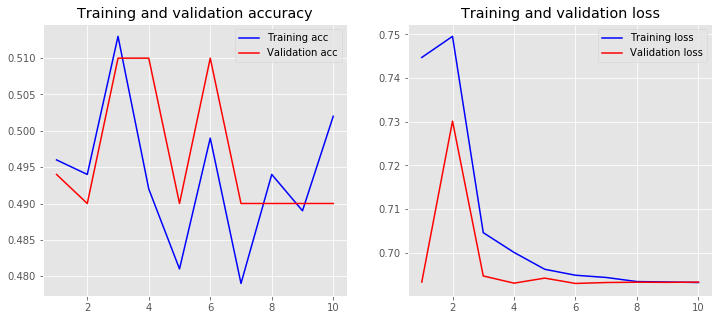

In [153]:
evaluation(train_test_Model,train_test_Model_history,traingen,testgen)

In [ ]:
# clear_session()

In [ ]:
#######################################################

In [331]:
# for_testgen , for_traingen
# list(df_for_traingen)[0][0][0][0].shape

In [337]:
def fit_model_(model,model_name,X_train,y_train,X_test=0,y_test=0,with_test=0):
    model_name = str(model_name)+".h5"
    if with_test!=0:
        history = model.fit(X_train, y_train,epochs=10,verbose=False,validation_data=(X_test, y_test))
    else:
        history = model.fit(X_train, y_train,epochs=10,verbose=False)
    model.save(model_name)
    return model , history , model_name

In [442]:
Model_without_first_layer = Model(shape=list(df_for_traingen)[0][0][0][0].shape,Type=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 94, 128)           89728     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 80, 128)           245888    
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 22, 128)           573568    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)              

In [356]:
for_traingen = load_object("for_traingen")

In [155]:
# lstm_X_train, lstm_X_test = first_layer_output[:X_train.shape[0]] , first_layer_output[-X_test.shape[0]:]

In [339]:
# for_traingen = (c for c in for_traingen)
# np.concatenate((a, b), axis=None)

In [340]:
# list(traingen)

In [369]:
for_traingen[0][]

(array([[[-4.33538016e-03,  1.03029737e-03,  4.40220349e-03, ...,
          -1.50252960e-03, -8.31206143e-03, -4.82566981e-03],
         [-2.94253230e-03,  3.19997128e-03,  6.91381190e-03, ...,
          -5.90384938e-03, -9.10405163e-03, -3.09362338e-04],
         [-2.15173885e-03,  3.10476101e-03,  1.70151144e-03, ...,
          -1.41103314e-02, -4.45966050e-03, -1.56333181e-03],
         ...,
         [ 1.31770049e-03,  1.19899111e-02,  1.17563864e-03, ...,
          -6.63181487e-03, -6.59608422e-03, -1.65103222e-04],
         [-1.25041348e-03,  8.64825677e-03, -8.95064091e-04, ...,
          -3.46428715e-03, -4.88419970e-03,  5.35254767e-05],
         [ 3.84541531e-03,  1.36503605e-02, -1.24383616e-04, ...,
          -4.37128730e-03, -1.93589786e-03, -8.34079110e-04]],
 
        [[ 1.13752589e-03,  7.35148555e-03,  4.88875574e-03, ...,
          -8.98361579e-03, -1.63664017e-02, -1.70112215e-02],
         [-6.02156250e-03,  8.12258478e-03,  6.52331067e-03, ...,
          -7.72033492

In [405]:
for_traingen[19][0][0].shape

(100, 100)

In [391]:
for_traingen[i][0][0][0]

array([-4.33538016e-03,  1.03029737e-03,  4.40220349e-03,  3.26751708e-03,
        9.71960952e-04, -8.72215629e-03,  1.13978414e-04, -9.59210657e-03,
        1.74429838e-03, -1.59154530e-03,  7.13769486e-03,  6.99908240e-03,
        7.35487835e-03,  7.05661671e-03, -2.27400498e-03, -6.25329278e-03,
        2.75308033e-03,  7.31687481e-03,  3.81290377e-03,  1.72818181e-04,
        1.29799987e-03, -5.76186180e-03, -1.05466635e-03, -4.56646085e-03,
        4.98215389e-03,  9.67363303e-04,  1.08257160e-02, -6.47894107e-03,
        2.00909446e-03, -7.09529873e-03,  5.98195475e-03, -4.27968474e-03,
       -1.34994718e-03,  2.86347698e-03, -2.19171564e-03, -6.57406682e-03,
        7.86344695e-04, -1.36983469e-02, -7.47051369e-03,  8.50019103e-04,
       -1.16144722e-04,  3.49828321e-03, -3.62730934e-03,  8.41027766e-04,
       -2.00680486e-04,  3.40364082e-03,  2.92397407e-03, -1.45730260e-03,
        2.92417919e-03,  6.85520004e-04,  1.57684740e-02,  1.20060444e-02,
       -5.62097784e-03, -

In [439]:
for_traingen[0][0][0].shape

(100, 100)

In [406]:
df = pd.DataFrame(columns=["ScriptPath","Label"])
x = []
y = []
for i in range(my_batch_size):
    for j in range(len(for_traingen[i][1])-1):
        x.append(for_traingen[i][0][j])
        y.append(for_traingen[i][1][j])
df["ScriptPath"] = x
df["Label"] = y

In [407]:
df.head()

,ScriptPath,Label
0,"[[-0.00433538, 0.0010302974, 0.0044022035, 0.0...",0.0
1,"[[0.0011375259, 0.0073514855, 0.0048887557, -0...",1.0
2,"[[-0.0055630635, 0.0036778878, 0.002881036, -0...",1.0
3,"[[0.005203909, 0.0037517848, -0.005205665, -0....",1.0
4,"[[0.004139867, 0.0064726085, -0.00440897, -0.0...",1.0


In [503]:
class CustomDataGen_(keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,batch_size,test=0,shuffle=True,sub_path="",df_path=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.sub_path = sub_path
        self.n = len(self.df[self.df.columns[0]])
        self.df_path = df_path
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        try:
            with open(self.sub_path+path) as js_file:
                script = js_file.read()
            script = sequence_of_syntax_units(script)
            return script
        except:
            return 'None'
    def __get_output(self, label):
        return label
#         return keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batches):
        if self.df_path == True:
            path_batch = batches[self.X_col['path']]

            name_batch = batches[self.y_col['name']]

            X_batch = np.asarray([self.__get_input(x) for x in path_batch]).astype('object')

            y_batch = np.asarray([self.__get_output(y) for y in name_batch]).astype('object')

            index = np.where(X_batch=='None')[0]

            np.delete(X_batch, index, axis=0)
            np.delete(y_batch, index, axis=0)

            X_batch  = preprocessing_dataset_(X_batch , test = self.test )

            X_batch = K.cast_to_floatx(X_batch)
            y_batch = K.cast_to_floatx(y_batch)
        else:
            
            path_batch = batches[self.X_col['path']]

            name_batch = batches[self.y_col['name']]

            X_batch = np.asarray([path_batch])

            y_batch = np.asarray([name_batch])

            X_batch = K.cast_to_floatx(X_batch)
            y_batch = K.cast_to_floatx(y_batch)
            
            X_batch = X_batch.reshape(20,100,100)
            y_batch = y_batch.reshape(-1,1)

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [504]:
# df.shape

In [505]:
df_for_traingen = CustomDataGen_(df,
                                X_col={'path':'ScriptPath'},
                                y_col={'name': 'Label'},
                                batch_size=my_batch_size,
                                sub_path='G:/JSContanaDataSet/',
                                test=0,
                                df_path = False
                               )

In [507]:
list(df_for_traingen)[1][0].shape

(20, 100, 100)

In [498]:
z.shape

(20, 100, 100)

In [463]:
# x = []
# y = []
# for i in range(my_batch_size):
#     print("========================")
#     x.append(for_traingen[i][0][0])
#     y.append(for_traingen[i][1][0])
# x = np.array(x)
# y = np.array(y)

In [508]:
Model_without_first_layer , Model_without_first_layer_history , Model_without_first_layer_name = fit_model(Model_without_first_layer,"Model_without_first_layer",df_for_traingen,with_test=0)

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [157]:
evaluation(Model_without_first_layer,Model_without_first_layer_history,lstm_X_train,y_train,lstm_X_test,y_test)

In [65]:
# clear_session()

In [ ]:
################################################################

In [ ]:

# file_to_read = open("stored_object.pickle", "rb")

# loaded_object = pickle.load(file_to_read)

# file_to_read.close()
# print(loaded_object)

# ss = np.asarray(["1", "www","2", "None","muawiyua",None,None]).astype('object')
# index = np.where(ss == None)[0]
# print(index)

# np.delete(ss, index, axis=0)

# l = []
# il = []
# i = 0 
# for s in ss:
#     if s!=None:
#         l.append(s)
#         il.append(i)
#     i+=1

# print(np.asarray(l))

In [35]:
# def fit_Model(model,model_name,X_train,y_train,X_test=0,y_test=0,chunk_size=10,with_test=0):
#     model_name = str(model_name)+".h5"
#     X_train_List = chunking_data(X_train,chunk_size)
#     y_train_List = chunking_data(y_train,chunk_size)
   
#     if with_test!=0:
#         X_test_List = chunking_data(X_test,chunk_size)
#         y_test_List = chunking_data(y_test,chunk_size)
#         history = model.fit(X_train_List[0], y_train_List[0],epochs=10,verbose=False,validation_data=(X_test_List[0], y_test_List[0]))
#     else:
#         history = model.fit(X_train_List[0], y_train_List[0],epochs=10,verbose=False)
            
#     model.save(model_name)
#     for i in range(1,len(X_train_List)-1):
#         model = load_model(model_name)
#         if with_test!=0:
#             model.fit(X_train_List[i], y_train_List[i],epochs=10,verbose=False,validation_data=(X_test_List[i], y_test_List[i]))
#         else:
#             model.fit(X_train_List[i], y_train_List[i],epochs=10,verbose=False)
#         loaded_train_test_model.save(model_name)    
#     return model , history , model_name

In [36]:
# def fit_model_(model,model_name,X_train,y_train,X_test=0,y_test=0,with_test=0):
#     model_name = str(model_name)+".h5"
#     if with_test!=0:
#         history = model.fit(X_train, y_train,epochs=10,verbose=False,validation_data=(X_test, y_test))
#     else:
#         history = model.fit(X_train, y_train,epochs=10,verbose=False)
#     model.save(model_name)
#     return model , history , model_name

In [126]:
# my_df = pd.read_csv('G:/JSContanaDataSet/script_path_data.csv')

# traingen = CustomDataGen(my_df.sample(1000),
#                          X_col={'path':'ScriptPath'},
#                          y_col={'name': 'Label'},
#                          batch_size=200,sub_path='G:/JSContanaDataSet/')

In [ ]:
# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)

In [158]:
# path_train_data = 'G:/JSContanaDataSet/script__df.csv'
# # num_words = 400000
# num_words = 400
# # maxlen = 1024
# maxlen = 100
# embedding_dim = 50
# myoptimizer = 'adam'
# myloss= 'binary_crossentropy'
# mymetrics = 'accuracy'


# # sentences_train, sentences_test, y_train, y_test = Read_data_and_split(path_train_data)
# # X_train,X_test = preprocessing_dataset(num_words,sentences_train,sentences_test,maxlen)
# # x_Data = np.concatenate((X_train, X_test), axis=0)
# # y_Data = np.concatenate((y_train, y_test), axis=0)

# Model for All Data

In [212]:
# Model_for_all_data = Model()

In [46]:
# Model_for_all_data , history , model_name = fit_model(Model_for_all_data,"Model_for_all_data",x_Data,y_Data,with_test=0)

In [213]:
# keras_function = K.function([Model_for_all_data.input], [Model_for_all_data.layers[1].output])
# first_layer_output = keras_function([x_Data, 1])
# save('first_layer_output.npy', first_layer_output[0])
# first_layer_output = load('first_layer_output.npy')

In [39]:
# clear_session()

# Model for train&test data

In [19]:
# train_test_Model = Model(vocab_size,embedding_dim,maxlen,myoptimizer,myloss,mymetrics)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1198000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 94, 128)           89728     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 56, 128)           409728    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 128)          

In [20]:
# train_test_Model , train_test_Model_history , train_test_Model_model_name = fit_model(train_test_Model,"train_test_Model",X_train,y_train,X_test,y_test,with_test=1)

Training Accuracy: 0.5040
Testing Accuracy:  0.5240


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.52      0.69       500

    accuracy                           0.52       500
   macro avg       0.50      0.26      0.34       500
weighted avg       1.00      0.52      0.69       500



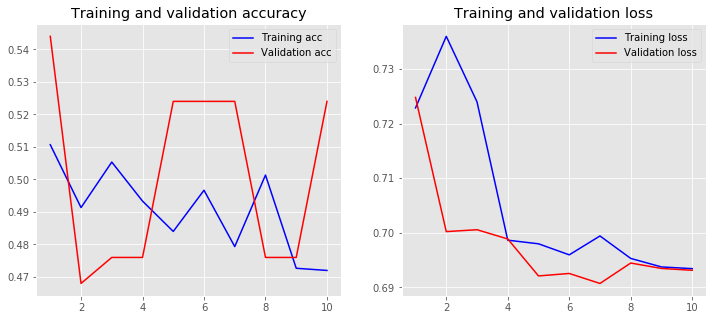

In [21]:
# evaluation(train_test_Model,train_test_Model_history,X_train,y_train,X_test,y_test)

In [ ]:
# clear_session()

# Model Without first LSTM layer

In [22]:
# Model_without_first_layer = Model(vocab_size,embedding_dim,maxlen,myoptimizer,myloss,mymetrics,shape=first_layer_output[0].shape,Type=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 94, 128)           89728     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 128)           573568    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [76]:
# lstm_X_train, lstm_X_test = first_layer_output[:X_train.shape[0]] , first_layer_output[-X_test.shape[0]:]

In [25]:
# Model_without_first_layer , Model_without_first_layer_history , Model_without_first_layer_name = fit_model(Model_without_first_layer,"Model_without_first_layer",lstm_X_train,y_train,lstm_X_test,y_test,with_test=1)

Training Accuracy: 0.5060
Testing Accuracy:  0.5220
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.52      0.69       499

    accuracy                           0.52       500
   macro avg       0.50      0.26      0.34       500
weighted avg       0.99      0.52      0.68       500



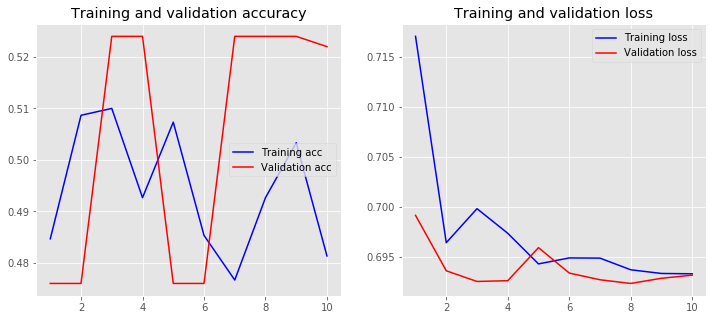

In [26]:
# evaluation(Model_without_first_layer,Model_without_first_layer_history,lstm_X_train,y_train,lstm_X_test,y_test)

In [65]:
# clear_session()